# Linear Function Approximation with Optimism

In [1]:
%matplotlib inline

import pandas as pd
import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import os
from tqdm import tqdm
from scipy.stats.qmc import LatinHypercube
import statsmodels.api as sm
# CHANGE THIS TO YOUR HOME DIRECTORY -- CENSORED AUTHOR NAME
os.environ["LD_LIBRARY_PATH"] = '$LD_LIBRARY_PATH:/home/AUTHORCENSORED/.mujoco/mujoco210/bin:/usr/lib/nvidia'

sys.path.append("core") 

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import RidgeCV

plt.style.use('matplotlibrc')
plt.rcParams['axes.formatter.useoffset'] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
#env = gym.envs.make("BipedalWalker-v3", hardcore=False)
env = gym.envs.make("Walker2d", exclude_current_positions_from_observation=False)

plt.style.use('matplotlibrc')
def x_sa(s,a):
    return np.hstack([s,a])

nStates = len(env.observation_space.sample())
nActions = 6
H = 20
Noff = 100

a_sampler = LatinHypercube(d=nActions)

observation_examples = np.array([x_sa(env.observation_space.sample(),
                                      np.random.uniform(-1,1,nActions)) for x in range(100000)])
#scaler = sklearn.preprocessing.StandardScaler()
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=10)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=10)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=10)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=10))
        ])
featurizer.fit(observation_examples)

def phi(X, featurizer):
    # if len(X.shape) <= 1:
    #     return np.hstack([np.ones((1,1)), X[None,:], featurizer.fit_transform(X[None,:])])
    # else:
    #     return np.hstack([np.ones((X.shape[:-1]))[...,None], X, featurizer.fit_transform(X)])
    # if len(X.shape) <= 1:
    #     return featurizer.fit_transform(X[None,:])
    # else:
    #     return featurizer.fit_transform(X)
    if len(X.shape) <= 1:
        return X[None,:]
    else:
        return X

def updateX(sa, phiX, featurizer):
    return np.vstack([phiX, phi(sa, featurizer)])

def get_sa(s, actions):
    #shape 100, nStates+nActions
    return x_sa(np.repeat(s[None,:],actions.shape[0],0),
                 actions)

# argmax that breaks ties!
def argmax(scores):
    return np.random.choice(np.where(scores == scores.max())[0])


def maxQ(s, w, featurizer, a_sampler, prec=None, lam=1):
    a_candidates = a_sampler.random(100)
    # phix is shape (100, d)
    phix = phi(get_sa(s, a_candidates), featurizer)
    # search over 100 actions
    scores = phix @ w
    if prec is not None:
        scores += lam*np.sqrt(np.diag(phix @ prec @ phix.T))
    #TODO: figure out reward distribution
    #scores = np.clip(scores, 0, 6*H)
    #scores = np.clip(scores, 0, 1)
    a_ind = argmax(scores)
    a = a_candidates[a_ind]
    return a, a_ind, scores[a_ind], phix

d = phi(observation_examples[-1], featurizer).shape[-1]

/home/kevin/anaconda3/envs/clap/lib/python3.8/site-packages/gym/envs/registration.py:563: UserWarning: WARN: Using the latest versioned environment `Walker2d-v4` instead of the unversioned environment `Walker2d`.
  logger.warn(


In [7]:
def collect_traj(env, w, phi, H, featurizer, a_sampler, unif=False):
    phiX = []
    env.reset()
    s = env.observation_space.sample()
    terminated = False
    states = []
    actions = []
    rewards = []
    nextstates = []
    for h in range(H):
        if terminated:
            s = np.zeros(s.shape)
            a = np.zeros(a.shape)
            r = 0
            sp = np.zeros(sp.shape)
        elif unif:
            a = a_sampler.random(1)
            phix = phi(get_sa(s,a), featurizer)
            a = a.squeeze()
            sp, r, terminated, _,_ = env.step(a)
            a_ind = 0
        else:
            a, a_ind, Qp, phix = maxQ(s, w, featurizer, a_sampler)
            #sp, r, terminated, _,_ = env.step(np.argmax(a)) # discrete actions
            sp, r, terminated, _,_ = env.step(a)
        #r = (r + 100)/400 # bipedal walker scaling
        #r = r/6/H # walker2d scaling
        states.append(s)
        actions.append(a)
        rewards.append(r)
        nextstates.append(sp)
        phiX.append(phix[a_ind])
    env.close()
    return [np.array(item) for item in 
            [phiX, states, actions, rewards, nextstates]]
        
def swaparrays(arr):
    return [np.array(item) for item in 
            list(
                map(list, 
                    zip(*arr)))]

def collect_dataset(env, w, phi, N, H, featurizer, a_sampler, unif):
    return swaparrays([collect_traj(env, w, phi, H, featurizer, a_sampler,
                                   unif=unif)
                             for n in range(N)])

phiX, states, actions, rewards, nextstates = \
                collect_dataset(env, np.random.uniform(-1,1,size=d)/d, 
                                phi, Noff, H, featurizer, a_sampler,
                               unif=True)

#5, unif false

In [4]:
phiX.shape

(50, 20, 64)

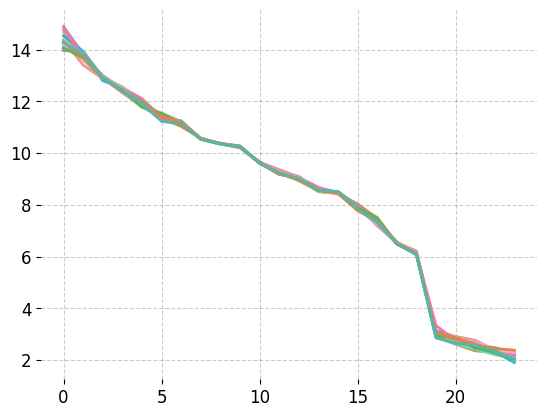

In [8]:
k = 19
Vts = np.linalg.svd(phiX.transpose(1,0,2), full_matrices=True)[2]
# projection to offline partition is k x d. 
# Offline partition is subspace spanned by top k singular vectors
# of the offline dataset
# USV^T, projection is VkVk^T
projOff = Vts[:,:k,:].transpose(0,2,1) @ Vts[:,:k,:]
#projOn = Vts[:,k:,:] #
# I - VkVk^T
projOn = np.eye(d) - projOff
plt.plot(np.linalg.svd(phiX.transpose(1,0,2), full_matrices=True)[1].T)
plt.show()

In [9]:
def lsvi(env, phiX, projOff, projOn, states, actions, rewards, nextstates, H, T, featurizer, sgd=False):
    d = phiX.shape[-1]
    w = np.random.uniform(-1,-1,size=d)
    errs = np.zeros((T, H))
    errs_off = np.zeros((T, H))
    errs_on = np.zeros((T, H))
    ws = np.zeros((T, H, d))
    n = phiX.shape[0]
    
    
    for t in tqdm(range(T)):
        # rollout under policy induced by w
        phi_traj, s_traj, a_traj, r_traj, sp_traj = \
                        collect_traj(env, w, phi, H, featurizer, a_sampler)
        
        phiX = np.concatenate([phiX, phi_traj[None,...]], axis=0)
        states = np.concatenate([states, s_traj[None,...]], axis=0)
        actions = np.concatenate([actions,a_traj[None,...]], axis=0)
        rewards = np.concatenate([rewards, r_traj[None,...]], axis=0)
        nextstates = np.concatenate([nextstates, sp_traj[None,...]], axis=0)
        
        # bellman backups, save bellman errors
        for h in reversed(range(H)):
            oldw = w
            if not sgd:
                prec = np.linalg.inv(phiX[:,h,:].T @ phiX[:,h,:] + 0.01*np.eye(d))
                if h == H-1:
                    Qp = np.zeros(rewards[:,0].shape)
                else:
                    _, _, Qp, phix = swaparrays([maxQ(sp, w, featurizer, a_sampler,
                                                     prec=prec) 
                                                 for sp in nextstates[:,h,:]]) #prec=prec
                projXoff = (projOff[None,...] @ phiX[:,:,:,None]).squeeze(-1)
                projXon = (projOn[None,...] @ phiX[:,:,:,None]).squeeze(-1)
                w = prec @ phiX[:,h,:].T @ (rewards[:,h]+Qp)

                err = 1/np.linalg.eigh(phiX[:,h,:].T @ phiX[:,h,:])[0][0]
                # 1/k-th smallest eigenvalue
                err_off = 1/np.linalg.eigh(projXoff[:,h,:].T @ projXoff[:,h,:])[0][k]
                # 1/(d-k)-th smallest eigenvalue
                err_on = 1/np.linalg.eigh(projXon[:,h,:].T @ projXon[:,h,:])[0][d-k]

            else:
                prec = None
                if h != H-1:
                    # SGD update on TD(1) error. Only to see if we can learn a policy
                    # This means we are not running LSVI-UCB anymore here
                    # Only update on one-episode error
                    _, _, Qp, _ = maxQ(nextstates[-1,h,:], w, featurizer, a_sampler, prec=prec) 
                    #print(np.linalg.norm(w), np.linalg.norm((phiX[-1,h,:] @ w - (Qp + rewards[-1,h])) * phiX[-1,h,:]))
                    w = w - 0.0001*(phiX[-1,h,:] @ w - (Qp + rewards[-1,h])) * phiX[-1,h,:]
                err = (phiX[Noff:,h,:].mean(0) @ (w - oldw)/d)**2
                err_off = None
                err_on = None
            ws[t,h] = w
            errs[t,h] = err
            errs_off[t,h] = err_off
            errs_on[t,h] = err_on
            
            
            #reg.fit(phiX[:,h,:], rewards[:,h]+Qp)
    return ws, errs, errs_off, errs_on, phiX, states, actions, rewards, nextstates


n_trials = 1
errs_hy_trials = []
errs_hy_off_trials = []
errs_hy_on_trials = []
errs_on_trials = []
errs_on_off_trials = []
errs_on_on_trials = []
for t in range(n_trials):
    ws_hy, errs_hy, errs_off_hy, errs_on_hy, phiX_hy, states_hy, actions_hy, rewards_hy, nextstates_hy = \
            lsvi(env, phiX, projOff, projOn, 
                 states, actions, rewards, nextstates, H, 100, featurizer,
                sgd=False)
    ws_on, errs_on, errs_off_on, errs_on_on, phiX_on, states_on, actions_on, rewards_on, nextstates_on = \
            lsvi(env, phiX[:1], projOff, projOn, 
                 states[:1], actions[:1], rewards[:1], nextstates[:1], H, 100, featurizer,
                sgd=False)
    errs_hy_trials.append(errs_hy)
    errs_hy_off_trials.append(errs_off_hy)
    errs_hy_on_trials.append(errs_on_hy)
    errs_on_trials.append(errs_on)
    errs_on_off_trials.append(errs_off_on)
    errs_on_on_trials.append(errs_on_on)

100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


100%|██████████| 3/3 [00:00<00:00, 308.26it/s]


Text(0.5, 0.99, 'Coverage Over Feature Space, Linear Function Approximation')

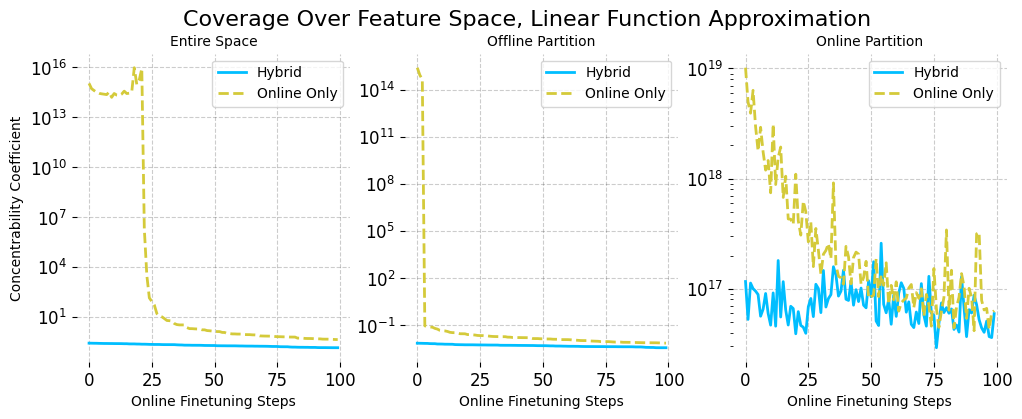

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
errs_parts_hy = [np.array(errs_hy_trials), np.array(errs_hy_off_trials), np.array(errs_hy_on_trials)]
errs_parts_on = [np.array(errs_on_trials), np.array(errs_on_off_trials), np.array(errs_on_on_trials)]
titles = ['Entire Space', 
          'Offline Partition', 
          'Online Partition']
for i in tqdm(range(3)):
    N = len(np.max(np.abs(errs_parts_on[i]),-1).mean(0))
    hy_arr = np.max(np.abs(errs_parts_hy[i]),-1)
    on_arr = np.max(np.abs(errs_parts_on[i]),-1)
    ax[i].plot(hy_arr.mean(0), linestyle='solid',
         label='Hybrid')
    ax[i].plot(on_arr.mean(0), linestyle='dashed',
         label='Online Only')
    ax[i].fill_between(np.arange(N),
                       hy_arr.mean(0) - hy_arr.std(0),
                       hy_arr.mean(0) + hy_arr.std(0),
                       alpha=0.3)
    ax[i].fill_between(np.arange(N),
                       on_arr.mean(0) - on_arr.std(0),
                       on_arr.mean(0) + on_arr.std(0),
                       alpha=0.3)
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Finetuning Steps', fontsize=10, y=0.05)
    ax[i].set_yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    #ax[i].set_ylim(-0.4,100)
ax[0].set_ylabel('Concentrability Coefficient', fontsize=10, x=0)

plt.suptitle('Coverage Over Feature Space, Linear Function Approximation', fontsize=16, y=0.99)
# higher UCB bonus
#plt.savefig('figs/cov_linear.png', dpi=300)

Text(0.5, 0.99, 'Coverage Over Feature Space, Linear Function Approximation')

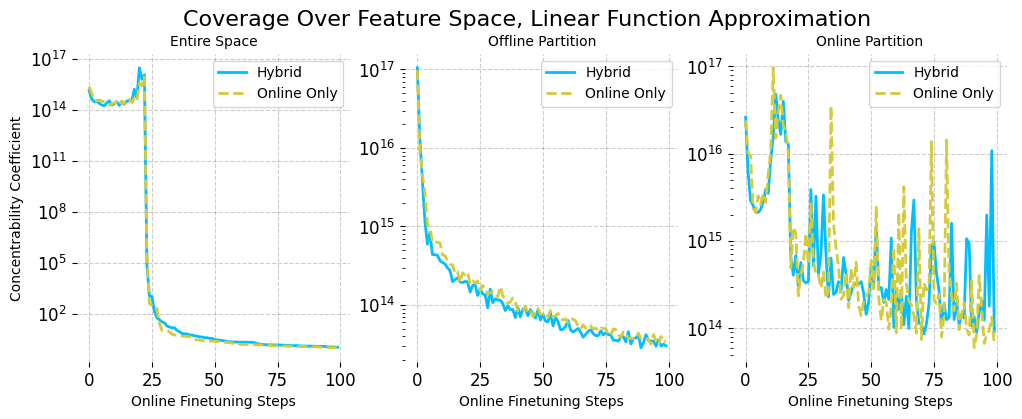

In [24]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
errs_parts_hy = [errs_hy, errs_off_hy, errs_on_hy]
errs_parts_on = [errs_on, errs_off_on, errs_on_on]
titles = ['Entire Space', 
          'Offline Partition', 
          'Online Partition']
for i in range(3):
    ax[i].plot(np.max(np.abs(errs_parts_hy[i]),1), linestyle='solid',
         label='Hybrid')
    ax[i].plot(np.max(np.abs(errs_parts_on[i]),1), linestyle='dashed',
         label='Online Only')
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Finetuning Steps', fontsize=10, y=0.05)
    ax[i].set_yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    #ax[i].set_ylim(-0.4,100)
ax[0].set_ylabel('Concentrability Coefficient', fontsize=10, x=0)

plt.suptitle('Coverage Over Feature Space, Linear Function Approximation', fontsize=16, y=0.99)
# higher UCB bonus
#plt.savefig('figs/cov_linear.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
errs_parts_hy = [errs_hy, errs_off_hy, errs_on_hy]
errs_parts_on = [errs_on, errs_off_on, errs_on_on]
titles = ['Entire Space', 
          'Offline Partition', 
          'Online Partition']
for i in range(3):
    ax[i].plot(np.median(np.abs(errs_parts_hy[i]),1), linestyle='solid',
         label='Hybrid')
    ax[i].plot(np.median(np.abs(errs_parts_on[i]),1), linestyle='dashed',
         label='Online Only')
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Finetuning Steps', fontsize=10, y=0.05)
    ax[i].set_yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    #ax[i].set_ylim(-0.4,100)
ax[0].set_ylabel('Concentrability Coefficient', fontsize=10, x=0)

plt.suptitle('Coverage Over Feature Space, Linear Function Approximation', fontsize=16, y=0.99)
# higher UCB bonus
#plt.savefig('figs/cov_linear.png', dpi=300)

In [ ]:
# #ws_on, errs_on, errs_off_on, errs_on_on, phiX_on, states_on, actions_on, rewards_on, nextstates_on = \
# #        lsvi(env, phiX[:1], states[:1], actions[:1], rewards[:1], nextstates[:1], H, 1000, featurizer,
# #            sgd=True)

# #plt.plot(pd.Series(rewards_hy[1000:].mean(1)).rolling(100).mean())
# #plt.plot(pd.Series(rewards_on.sum(1)).rolling(10).mean())



# try:
#     err = np.inf
#     err_off = np.inf
#     err_on = np.inf
#     # kth eigenvalue of PAP^{-1} is first one in subspace
#     err_off = np.linalg.svd(
#                     np.linalg.inv(
#                         projOff[h] @ phiX[n:,h,:].T @ phiX[n:,h,:] @ projOff[h].T))[1][k]
#     err_on = np.linalg.svd(
#                     np.linalg.inv(
#                         projOn[h] @ phiX[n:,h,:].T @ phiX[n:,h,:] @ projOn[h].T))[1][d-k]
